Projet 5 - Segmentez des clients d'un site e-commerce - Cleaning  
Base de données relationnelle  

Classification non-supervisée selon 3 critères:
- Recency: durée écoulée depuis la dernière commande du client
- Frequency: #commandes du client (potentiellement à diviser par la durée totale pendant laquelle le client a été actif, mais vu que certains n'ont fait qu'une seule commande je ne vais pas faire ce calcul pour l'instant)
- Monetary: somme totale dépensée
(On fait au plus simple avec uniquement ces 3 features car les algorithmes de clustering sont lourds en calcul.)

Puis choix d'initiative à prendre pour chaque classe obtenue.  
Enfin, raisonnement sur fréquence de màj de cette classification.  

- kmeans
- dbscan
- agglomerative clustering/hiérarchique statquest les décrit bien

car algos de clustering lourds (donc virer zipcode)
"subsampling"

>-
# 1. Initialisation, visualization

>>-
## 11. Imports

>>>-
### 111. Package imports

In [1]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
sns.set_style("whitegrid")      # "ticks", "white"
import re
import my
import datetime
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
#import os
#import sys
from IPython.display import clear_output
import warnings

>>>-
### 112. Data imports

In [2]:
dfs1 = pd.read_csv("olist_customers_dataset.csv") #, sep="\t")
dfs2 = pd.read_csv("olist_geolocation_dataset.csv") #, sep="\t")
dfs3 = pd.read_csv("olist_order_items_dataset.csv") #, sep="\t")
dfs4 = pd.read_csv("olist_order_payments_dataset.csv") #, sep="\t")
dfs5 = pd.read_csv("olist_order_reviews_dataset.csv") #, sep="\t")
dfs6 = pd.read_csv("olist_orders_dataset.csv") #, sep="\t")
dfs7 = pd.read_csv("olist_products_dataset.csv") #, sep="\t")
dfs8 = pd.read_csv("olist_sellers_dataset.csv") #, sep="\t")
dfs9 = pd.read_csv('product_category_name_translation.csv') #, sep='\t')
dfs = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, dfs7, dfs8, dfs9]

Je ne suis pas très content de cette solution pour pouvoir itérer sur les 9 df car je crée un objet dfs gigantesque, alors que je veux juste une liste qui renvoie vers chacun des 9 df sans contenir leur contenu.

>>-
## 12. Mise en forme du df

In [3]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)
for df in dfs:
    #print(list(df.columns))
    display(df.head(1))
    display(df.shape)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


(99441, 5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


(1000163, 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


(112650, 7)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


(103886, 5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


(99224, 7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


(99441, 8)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


(32951, 9)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


(3095, 4)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


(71, 2)

- dfs1 me permettra de remonter au customer unique id à partir du customer id des autres tableaux donc je le garde. J'en retirerai peut-être les données géographiques si elles ont une feature importance basse.
- dfs2 donne juste d'autres façons de traduire les données géographiques. Il ne me servira pas.
- dfs3 donne une date, un prix et un prix de livraison pour chaque commande. Je le garde.
- dfs4 donne le prix de chaque commande. Est-ce redondant avec dfs3 ? À voir.
- dfs5 donne pour chaque commande la note/commentaire laissé par le client. Peut-être que je pourrai m'en servir juste pour savoir pour chaque client le taux de commandes qu'il a notées et que ça aiderait la classification mais j'y crois peu donc je retire ce tableau.
- dfs6 donne la correspondance entre customer id et order id. Il donne aussi la date d'achat, qui devrait être importante. Date redondante avec dfs3 ?
- dfs7 donne des infos sur les produits. Inutile.
- dfs8 donne les données géographiques du vendeur. Inutile.
- dfs9 est une traduction ES-EN de données inutiles.

>>>-
### 121. Merge

In [4]:
keeps = ["customer_unique_id","order_purchase_timestamp","payment_value"]

In [5]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1[["customer_id","customer_unique_id"]].merge(dfs6[["customer_id","order_id","order_purchase_timestamp"]], on="customer_id", how="outer")
print("df  : " + str(df.shape))
#print("dfs3: " + str(dfs3.shape))
#df = df.merge(dfs3[["order_id","price","freight_value"]], on="order_id", how="outer")
#print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4[["order_id","payment_value"]], on="order_id", how="outer")
print("df  : " + str(df.shape))

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 4)
dfs4: (103886, 5)
df  : (103887, 5)


Le df final fait une ligne de plus que le dfs4.  
Il y a donc soit un doublon qui a été créé soit une entrée du {dfs1 + dfs6} a un "order_id" qui n'existe pas dans dfs4.

In [6]:
new_elt = list(set(df.order_id).difference(set(dfs4.order_id)))
display(df[df.order_id == new_elt[0]])

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,payment_value
22061,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,NaN


Vu que cet achat n'existe pas dans dfs4 il n'a pas de donnée renseignée pour la colonne payment_value.  
Je décide de faire comme s'il n'existait pas et je supprime cet élément:

In [7]:
df = df[df.order_id != new_elt[0]]
df.shape
df = my.resindx(df)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103886, 5)


Je nettoie les colonnes inutiles:

In [8]:
df = df[keeps]
df.head(2)

,customer_unique_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48


>>>-
### 122. Duplicates

In [9]:
df[df.duplicated(keep=False) == True]

,customer_unique_id,order_purchase_timestamp,payment_value
312,a1864cdd58debf5031958069ee937742,2017-11-26 15:11:19,189.88
313,a1864cdd58debf5031958069ee937742,2017-11-26 15:11:19,189.88
539,8f601c7d9263ca954656792b02517b3b,2018-04-04 19:21:32,20.00
540,8f601c7d9263ca954656792b02517b3b,2018-04-04 19:21:32,20.00
541,8f601c7d9263ca954656792b02517b3b,2018-04-04 19:21:32,20.00
...,...,...,...
103662,6d443b75cff956bb73dce7385033e266,2017-09-05 09:29:17,83.59
103666,b6108acc674ae5c99e29adc1047d1049,2017-05-05 19:08:38,199.64
103667,b6108acc674ae5c99e29adc1047d1049,2017-05-05 19:08:38,199.64
103787,514f2a78d07928478ac9212b21b7acbc,2017-07-12 15:40:39,7.30


Il y a beaucoup de duplicates.  
J'espère que ce sont juste des clients qui ont acheté plusieurs exemplaires d'un même article à la fois.

>>>-
### 123. Subsampling ?
Ça accélèrerait grandement le striptime qui suit et surtout les clusterings, mais en même temps j'aimerais que ma solution finale ne laisse aucun client de côté donc pour l'instant je garde tout malgré les longs calculs.

>>>-
### 124. Réorganisation vers RFM

In [10]:
df.groupby("customer_unique_id").count().head(2)

,order_purchase_timestamp,payment_value
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1


In [11]:
df.groupby("customer_unique_id").count()[df.groupby("customer_unique_id").order_purchase_timestamp.count() > 2].head(2)

,order_purchase_timestamp,payment_value
customer_unique_id,,
0058f300f57d7b93c477a131a59b36c3,3,3
00a9fd000ff87bb48b989df819c418f5,4,4


In [12]:
datetime.datetime.now()

datetime.datetime(2022, 10, 18, 22, 36, 54, 526609)

In [13]:
df.order_purchase_timestamp.max()

'2018-10-17 17:30:18'

In [14]:
#J'arrête de run cette cell car c'est trop long.
#Naturellement ça va causer une erreur juste en-dessous.
#Faut relancer à partir de dfs = pd.read("dfs_1.csv")

#Évidemment le mieux serait que je fasse mon subsampling avant cette présente cell mais
#dans le souci de "non cleané, pour comprendre votre démarche" je garde tout ceci dans l'ordre de mon raisonnement et
#juste je script echo ces quelques cells

#t0 = datetime.datetime.now()
t0 = datetime.datetime.strptime(df.order_purchase_timestamp.max(), "%Y-%m-%d %H:%M:%S") # %S.%f s'il y a les millièmes de seconde.
tt = pd.Series(name="recency")
for i in range(df.shape[0]):
    tt.loc[i] = (t0 - datetime.datetime.strptime(df["order_purchase_timestamp"][i], "%Y-%m-%d %H:%M:%S")).total_seconds()
tt.head(2)

C:\Users\achou\AppData\Local\Temp\ipykernel_20608\1763167247.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tt = pd.Series(name="recency")


0    44850283.0
1    24007314.0
Name: recency, dtype: float64

C'est giga long ce striptime pour chaque élément de la series. (environ 3min)

In [15]:
df["recency"] = tt

In [16]:
dfs = pd.DataFrame()
dfs["R"] = df.groupby("customer_unique_id").recency.min()
dfs["F"] = df.groupby("customer_unique_id").order_purchase_timestamp.count()
dfs["M"] = df.groupby("customer_unique_id").payment_value.sum()
dfs

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1,27.19
0000f46a3911fa3c0805444483337064,50617515.0,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,31957237.0,1,43.62
0004aac84e0df4da2b147fca70cf8255,29108676.0,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,42841782.0,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,26860942.0,1,84.58
ffff371b4d645b6ecea244b27531430a,53314862.0,1,112.46


In [17]:
dfs.to_csv("dfs_1.csv")
dfs_1 = dfs.copy()

In [18]:
dfs = pd.read_csv("dfs_1.csv")

>>-
## 13. Visualisation

In [19]:
def hstplot(seris, strlog='log de ', hstsize=20):
    hst = seris.copy()
    hst.replace([np.inf, -np.inf], np.nan, inplace=True)
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'], hst['hst_val'], legend=None, s=hstsize)
    plt.title(('Hist de ' + strlog + co),fontsize=16)
    plt.xlabel((strlog + co),fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
    plt.legend

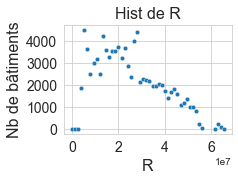

In [20]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["R"], strlog='')
print()

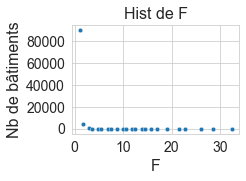

In [21]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["F"], strlog='')
print()

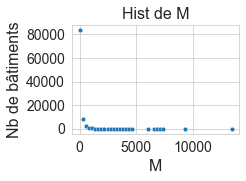

In [22]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["M"], strlog='')
print()

In [23]:
display(dfs.head(1))
dfs.F = np.log(1+dfs.F)/np.log(2)
dfs.M = np.log(1+dfs.M)/np.log(2)
dfs.head(1)

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.9


,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1.0,7.158862


In [24]:
dfs.to_csv("dfs_log.csv")
dfs_log = dfs.copy()

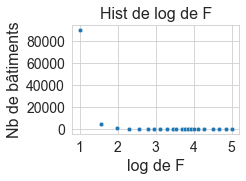

In [49]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_log.F, strlog='log de ')
print()

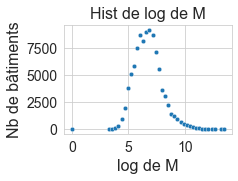

In [26]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_log.M, strlog='log de ')
print()

In [50]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [51]:
dfs.to_csv("dfs_loglog.csv")
dfs_loglog = dfs.copy()

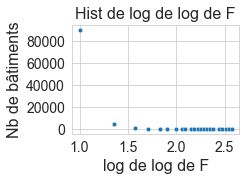

In [52]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_loglog.F, strlog='log de log de ')
print()

In [53]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [54]:
dfs.to_csv("dfs_logloglog.csv")
dfs_logloglog = dfs.copy()

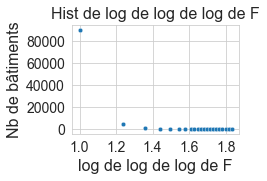

In [55]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_logloglog.F, strlog='log de log de log de ')
print()

In [56]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [57]:
dfs.to_csv("dfs_loglogloglog.csv")
dfs_loglogloglog = dfs.copy()

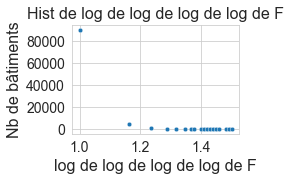

In [58]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_loglogloglog.F, strlog='log de log de log de log de ')
print()

Clairement la solution n'est pas dans cette direction.

>-
# 2. Cleaning

>>-
## 21. Missing values

In [30]:
df.isna().sum()

customer_unique_id          0
order_purchase_timestamp    0
payment_value               0
recency                     0
dtype: int64

In [31]:
dfs.isna().sum()

customer_unique_id    0
R                     0
F                     0
M                     0
dtype: int64

>>-
## 22. Imputation

In [32]:
%%script echo
for co in dfs.columns:
    dfs.loc[dfs[co].isna(),co] = dfs[co].mean()

Couldn't find program: 'echo'


J'aurais utilisé le mean() pour Recency et Monetary (celui après log) car on a affaire à une distribution qui est quasiment une distribution normale.  
Pour Frequency par contre même après passage au log on a toujours un skewness grand, car il est extrêmement rare qu'un client ait fait plus d'un achat dans le cas de ce dataset, donc j'aurais probablement imputé par median().

>-
# 3. Subsampling
  
  ATTENTION ! Finalement je me suis rendu compte que cette méthode est problématique et j'ai donc utilisé dfs_2 dans mon notebook de clustering plutôt que dfs_3, avec un subsampling standard.  
  
Je me suis vite rendu compte dans le notebook de clustering que mon df est bien trop grand.  
Je décide donc de le réduire fortement ici.  
Je tente de sortir tous les clients qui n'ont fait qu'un seul achat. En effet, pour eux je n'ai que R et M. Je peux juste savoir si leur unique achat est récent ou non et s'il est cher ou non. Ça me fera donc au maximum 4 catégories (pour lesquelles je n'ai pas encore déterminé le threshold de prix ni le threshold de date) avec comme stratégies marketing:
- old + cheap: Un simple mail "Vous nous manquez."
- old + expensive: "Vous avez acheté tel truc à tel date. Est-ce qu'il fonctionne toujours ? Voulez-vous tester un autre modèle ?"
- recent + cheap: "Donnez-nous votre avis sur cet achat" ou "Venez voir les bons plans de cette semaine"
- recent + expensive: "Tel article et tel article vont super bien avec l'article que vous avez acheté. Est-ce que ça vous intéresse ?"

In [33]:
print(dfs.shape)

(96095, 4)


In [34]:
display(dfs.head(2))
dfs = dfs_1[dfs_1.F > 1]
print(dfs.shape)
dfs.head(2)

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1.0,7.158862
1,0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1.0,4.817112


(5729, 3)


,R,F,M
customer_unique_id,,,
000e309254ab1fc5ba99dd469d36bdb4,9876981.0,2,78.42
00172711b30d52eea8b313a7f2cced02,5645771.0,2,244.14


In [35]:
dfs.to_csv("dfs_2.csv")
dfs_2 = dfs.copy()